In [ ]:
import pandas as pd
import pickle
import seaborn as sns
sns.set()
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyoff
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold._t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
palette = sns.color_palette("bright", 10)
from sklearn.decomposition import PCA
import faiss
from sklearn.cluster import KMeans

TSNE AND PCA for Extracted Features

In [ ]:
def read_file(path):

    """
        Inputs: Feature File Path
        Ouputs: A Dataframe with File Name and corresponding Extracted Feature List
    """
    
    file_dict = pd.read_pickle(path)
    df = pd.DataFrame(file_dict.items(),columns=['Name','Feature_Value'])
    return df
    
def read_file_each_feature(path):

    """
        Inputs: Feature file Path
        Ouputs: A Dataframe with file names and extracted features(Each feature has a separate column)
    """
    
    file_dict = pd.read_pickle(path)
    df = pd.DataFrame(file_dict.items(),columns=['Name','Feature_Value'])
    columns = []
    for i in range(1024):
        columns = columns + [str(i)]
    df_final = pd.DataFrame(df['Feature_Value'].to_list(),columns = columns)
    df_final['Name'] = df['Name']
  
    return df_final

def dataset_labels(csv_file_path):
    """
        Inputs: Data CSV file with labels
        Outputs: a dictionary with labels and sample ids.
    """

    labels_df = pd.read_csv(csv_file_path)
    labels_df = labels_df.dropna()
    labels_df.astype(int)
    labels_dict = {}
    files_list = labels_df['Sample ID'].to_list()
    grade = labels_df['Sample Grade'].to_list()

    for i in range(len(files_list)):
        labels_dict[int(files_list[i])] = int(grade[i])
    
    return labels_dict

In [ ]:
# df = read_file('/content/drive/MyDrive/MITACS/FineTuned_Model_Features_dict.pickle')
df = read_file_each_feature('/content/drive/MyDrive/MITACS/FineTuned_Model_Features_dict.pickle')
labels_dict = dataset_labels('/content/drive/MyDrive/MITACS/Data.csv')

In [ ]:
file_names = df['Name'].to_list() # Get the list of Patches Names(File Paths)

In [ ]:
# ((file_names[0]).split(' ')[1]).split('.')[0] # Extracting Sample ID from whole File Path

'362'

In [ ]:
# seq_list = []
# for name in file_names:

#     if ((name).split(' ')[1]).split('.')[0] == '632':
#         seq_list = seq_list + [name]


In [ ]:
#Add Grade Column to the dataframe and Add entries to the column for each image patch

df['Grade'] = ""
i = 0
list_Temp = df['Name'].to_list()
label_list = []
for patch in list_Temp:
    label = labels_dict[int(((patch).split(' ')[1]).split('.')[0])]
    label_list = label_list + [label]
    print(len(label_list))

In [ ]:
df['Grade'] = label_list

In [ ]:
X = []  # Get the Extracted Feature List for Each Image Patch
for i in range(len(label_list)):
    X = X + [((df.iloc[i]).values.flatten().tolist())[:1024]]

In [ ]:
tsne = TSNE()
X_embedded = tsne.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



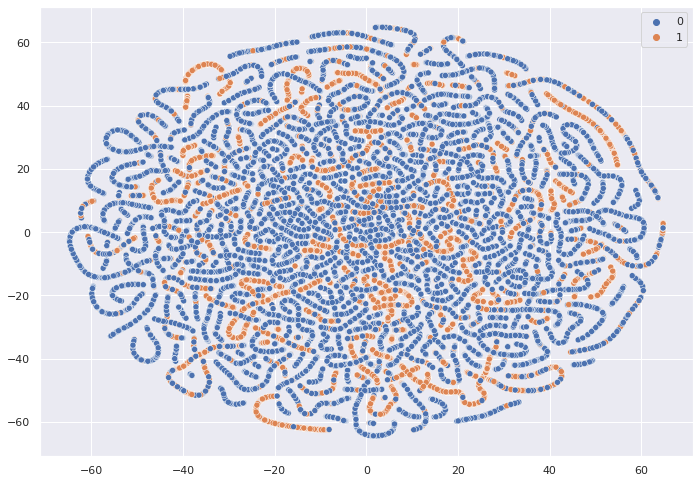

In [ ]:
# TSNE Visualization
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=label_list, legend='full')

In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
feat_cols = [str(i) for i in range(1024)]

### PCA Analysis

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.92626787 0.04485811 0.02028938]


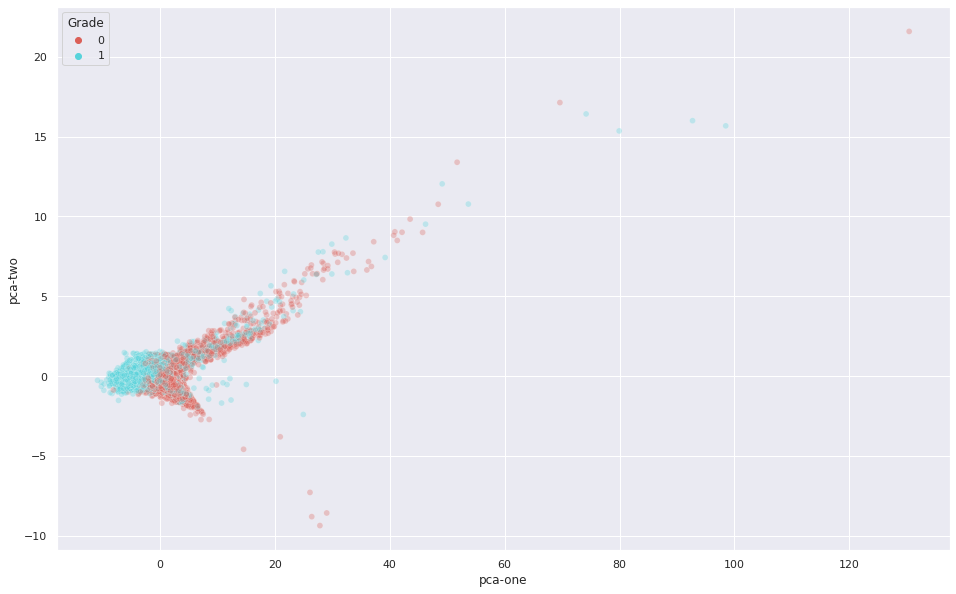

In [ ]:
# PCA visualization using Scatterplot
# pca-one and pca-two component visualization
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="Grade",
    palette=sns.color_palette("hls", 2),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

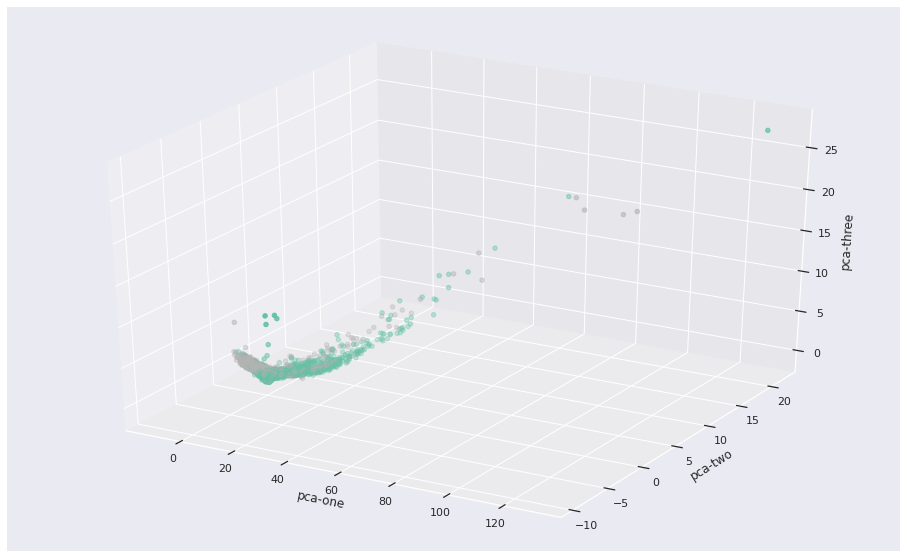

In [ ]:

# Visualizing All Three PCA components
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["Grade"], 
    cmap='Set2'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### PCA and TSNE on a subset

In [ ]:
N = 10000
# Selecting  A Subset of Samples for TSNE Visualization ( Randomly selecting N samples)
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]

TSNE on a subset of patches

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 3.171s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.085052
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.061211
[t-SNE] KL divergence after 300 iterations: 2.189859
t-SNE done! Time elapsed:

## TSNE and PCA visualization for Subset of Samples

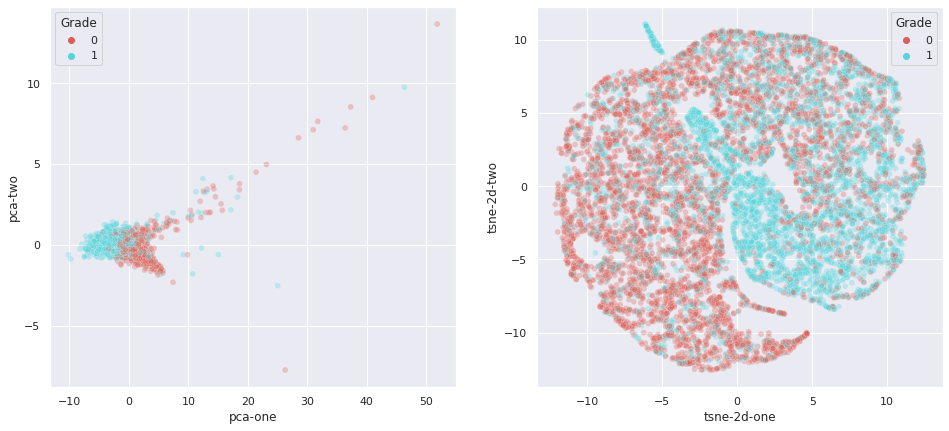

In [ ]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="Grade",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Grade",
    palette=sns.color_palette("hls",2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

## Using 10 PCA components and Then Performing TSNE

In [ ]:
pca_10 = PCA(n_components=10)
pca_result_10 = pca_10.fit_transform(data_subset)
print('Cumulative explained variation for 10 principal components: {}'.format(np.sum(pca_10.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.999293863773346


In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_10)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_subset['tsne-pca10-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca10-two'] = tsne_pca_results[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 16.30262017250061 seconds


Visualization of all Three Together.
1. PCA
2. TSNE
3. PCA + TSNE

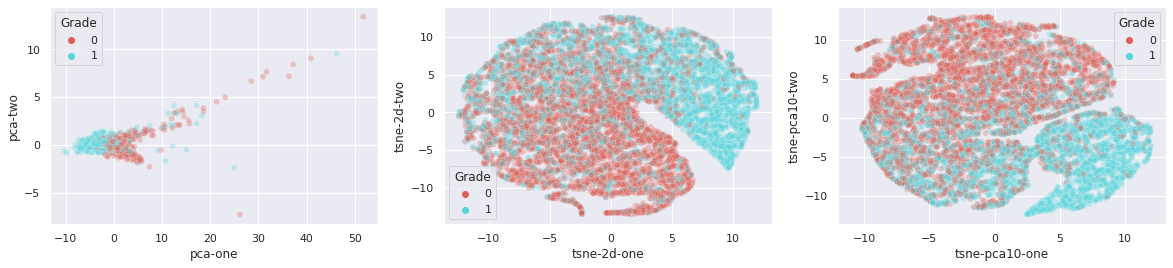

In [ ]:

plt.figure(figsize=(20,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="Grade",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Grade",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca10-one", y="tsne-pca10-two",
    hue="Grade",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)

## Clustering Image Patches On Basis of Extracted Features

In [ ]:
file_dict = pd.read_pickle('/content/drive/MyDrive/MITACS/FineTuned_Model_Features_dict.pickle')
df = pd.DataFrame(file_dict.items(),columns=['Name','Feature_Value'])
slide_data = {}
patch_list = df['Name'].to_list()
feature_list = df['Feature_Value'].to_list()

PCA And Kmeans Using sklearn library

In [ ]:
pca = PCA(n_components=10,random_state=23)
pca.fit(feature_list)
values_transformed = pca.transform(feature_list)


number_of_clusters = 9  # Number of Clusters Can Be Changed
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(values_transformed)

KMeans(n_clusters=9)

In [ ]:
data_frame = pd.DataFrame(patch_list,columns = ['filename'])
data_frame['Cluster'] = kmeans.labels_

In [ ]:
data_frame.to_csv('/content/drive/MyDrive/MITACS/test_clusters.csv') #Change Path And file name to store the cluster file

In [ ]:
clusters = {}
for file,cluster in zip(patch_list,kmeans.labels_):
    if cluster not in clusters.keys():
        clusters[cluster] = []
        clusters[cluster].append(file)
    else:
        clusters[cluster].append(file)

In [ ]:
#Cluster Visualization. Visualize the Clusters By Running This Cell. 
for number in range(ncentroids):

        fig = plt.figure(figsize = (30,30))
        files = clusters[number]

        if len(files) > 10:
            files = random.sample(files,10) # 10 Random Files are selected from each cluster. Each Run display Different Files
        for index,file in enumerate(files):
            plt.subplot(5,5,index+1)
            name = file.split('/')[-1]
            img = Image.open(file)
            img = np.array(img)
            plt.imshow(img)
            plt.axis('off')
            plt.title(name ,fontsize = 7)